<a href="https://colab.research.google.com/github/enwachukwu/abc/blob/main/Third_Convolutional_N_N_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from __future__ import print_function
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import ELU
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau



In [ ]:
# Set parameters
image_size = 256
batch_size = 32
EPOCHS = 10
num_classes = 17

In [ ]:
# define data directories
train_data_dir = '/content/drive/MyDrive/17_flowers/train'
test_data_dir = '/content/drive/MyDrive/17_flowers/test'

In [ ]:
# Create an instance of the ImageDataGenerator class with various transformations parameters.
datagen = ImageDataGenerator(
    horizontal_flip=True,
    vertical_flip=True,
    rotation_range=40,
    width_shift_range=0.1,
    height_shift_range=0.1,
    rescale=1/255,
    fill_mode='nearest',
    brightness_range=[0.5, 1.5],
    validation_split=0.1
)


In [ ]:

train_generator = datagen.flow_from_directory(
        train_data_dir,  # Directory where the training data is located
        target_size = (image_size, image_size),  # Dimensions to which all images found will be resized
        batch_size=batch_size,  # Size of the batches of data
        class_mode='categorical',  # Because we use categorical_crossentropy loss, we need categorical labels
        subset='training')  # Specifies this is the training subset of data (in conjunction with 'validation_split' in 'datagen')

Found 1071 images belonging to 17 classes.


In [ ]:

validation_generator = datagen.flow_from_directory(
        train_data_dir,  # Directory where the training data is located (validation data is often in the same place)
        target_size = (image_size, image_size),  # Dimensions to which all images found will be resized
        batch_size=batch_size,  # Size of the batches of data
        class_mode='categorical',  # Because we use categorical_crossentropy loss, we need categorical labels
        subset='validation',  # Specifies this is the validation subset of data (in conjunction with 'validation_split' in 'datagen')
        shuffle=False)  # Data will be read in order, without shuffling

Found 119 images belonging to 17 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1.0 / 255)

In [ ]:

test_generator = test_datagen.flow_from_directory(
        test_data_dir,  # Directory where the test data is located
        target_size=(image_size,image_size),  # Dimensions to which all images found will be resized
        batch_size=batch_size,  # Size of the batches of data
        class_mode='categorical',  # Because we use categorical_crossentropy loss, we need categorical labels
        shuffle=False)  # Data will be read in order, without shuffling, to keep correspondence with true labels



Found 170 images belonging to 17 classes.


In [ ]:
# Initialize a Sequential model. The Sequential model is a linear stack of layers.
model = Sequential()

# First CONV-ReLU Layer
model.add(Conv2D(64, (3, 3), padding='same', input_shape=(image_size, image_size, 3)))

# Apply the ReLU activation function.
model.add(Activation('relu'))

# Batch normalization layer normalizes the activations of the previous layer, which can speed up training.
model.add(BatchNormalization())

# Second CONV-ReLU Layer

# Another convolutional layer with the same configurations as above.
model.add(Conv2D(64, (3, 3), padding = "same", input_shape = (image_size, image_size, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout

# Max pooling layer to down-sample the feature maps, which helps to reduce the spatial dimensions.
model.add(MaxPooling2D(pool_size=(2, 2)))

# Dropout layer randomly sets a fraction (20% in this case) of input units to 0 at each update during training,
# which helps to prevent overfitting.
model.add(Dropout(0.2))

# 3rd and 4th set of CONV-ReLU Layers
# Similar to the first and second, but increasing the filters to 128.
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# 5th and 6th set of CONV-ReLU Layers
# Similar to previous sets, but increasing the filters to 256.
model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), padding="same"))
model.add(Activation('relu'))
model.add(BatchNormalization())

# Max Pooling with Dropout
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

# First set of FC or Dense Layers

# Flatten layer reshapes the 3D output of the last convolutional layers to 1D.
model.add(Flatten())

# Fully connected (Dense) layer with 256 neurons.
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Second set of FC or Dense Layers
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Final Dense Layer

# A final fully connected layer with 'num_classes' neurons.
# It uses the softmax activation function to produce probabilities for each class.
model.add(Dense(num_classes))
model.add(Activation("softmax"))





In [ ]:
print(model.summary())

In [ ]:
def custom_loss(y_true, y_pred):
    return tf.keras.losses.categorical_crossentropy(y_true, y_pred, label_smoothing=0.1)

# Compile the model with the Adam optimizer and a learning rate of 0.0001.
# The loss function is the custom function defined above, and the model will also track accuracy as a performance metric.
model.compile(optimizer=Adam(0.0002), loss=custom_loss, metrics=['accuracy'])

# Calculate the number of steps per epoch for training and validation.
# This is done by dividing the total number of samples by the batch size for each generator.
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

# Define a callback to reduce the learning rate if the validation accuracy plateaus.
# The learning rate will be reduced by multiplying it by a factor of 0.2 if the accuracy does not improve after 2 epochs.
# The reduction is subject to certain constraints to prevent it from decreasing below a minimum threshold.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

# Define a callback for early stopping to prevent overfitting.
# Training will stop if the validation accuracy does not improve by at least 0.0001 for 20 consecutive epochs.
# If training is halted, the model will revert to the weights of the epoch with the best observed validation accuracy.
earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 20,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

# Define a callback for model checkpoints to save the model architecture and weights.
# This callback saves the model after every epoch where the validation accuracy improves.
# Only the best performing model will be saved, and it will be stored in the file 'model.h5'.
checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = 'model2',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = False,
                                                  mode = 'max')

# Group the callbacks into a list that can be passed to the model training function.
callbacks = [earlystopping, reduce_lr, checkpointer]

In [ ]:
# Define callbacks for early stopping, model checkpoint, and learning rate reduction
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001, verbose=1)

# List of callbacks
callbacks = [early_stopping, model_checkpoint, reduce_lr]

In [ ]:
history= model.fit(train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = validation_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = EPOCHS,
          callbacks = callbacks)

Epoch 1/10
33/33 [==============================] - ETA: 0s - loss: 3.7689 - accuracy: 0.1174
Epoch 1: val_loss improved from inf to 3.28300, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 51s 1s/step - loss: 3.7689 - accuracy: 0.1174 - val_loss: 3.2830 - val_accuracy: 0.0521 - lr: 2.0000e-04
Epoch 2/10
33/33 [==============================] - ETA: 0s - loss: 3.2174 - accuracy: 0.1973
Epoch 2: val_loss did not improve from 3.28300
33/33 [==============================] - 35s 1s/step - loss: 3.2174 - accuracy: 0.1973 - val_loss: 3.5525 - val_accuracy: 0.0208 - lr: 2.0000e-04
Epoch 3/10
33/33 [==============================] - ETA: 0s - loss: 2.9665 - accuracy: 0.2320
Epoch 3: val_loss did not improve from 3.28300
33/33 [==============================] - 38s 1s/step - loss: 2.9665 - accuracy: 0.2320 - val_loss: 3.9254 - val_accuracy: 0.0000e+00 - lr: 2.0000e-04
Epoch 4/10
33/33 [==============================] - ETA: 0s - loss: 2.8440 - accuracy: 0.2599
Epoch 4: val_loss did not improve from 3.28300
33/33 [==============================] - 38s 1s/step - loss: 2.8440 - accuracy: 0.2599 - val_loss: 5.4200 - val_accuracy: 0.0729 - lr: 

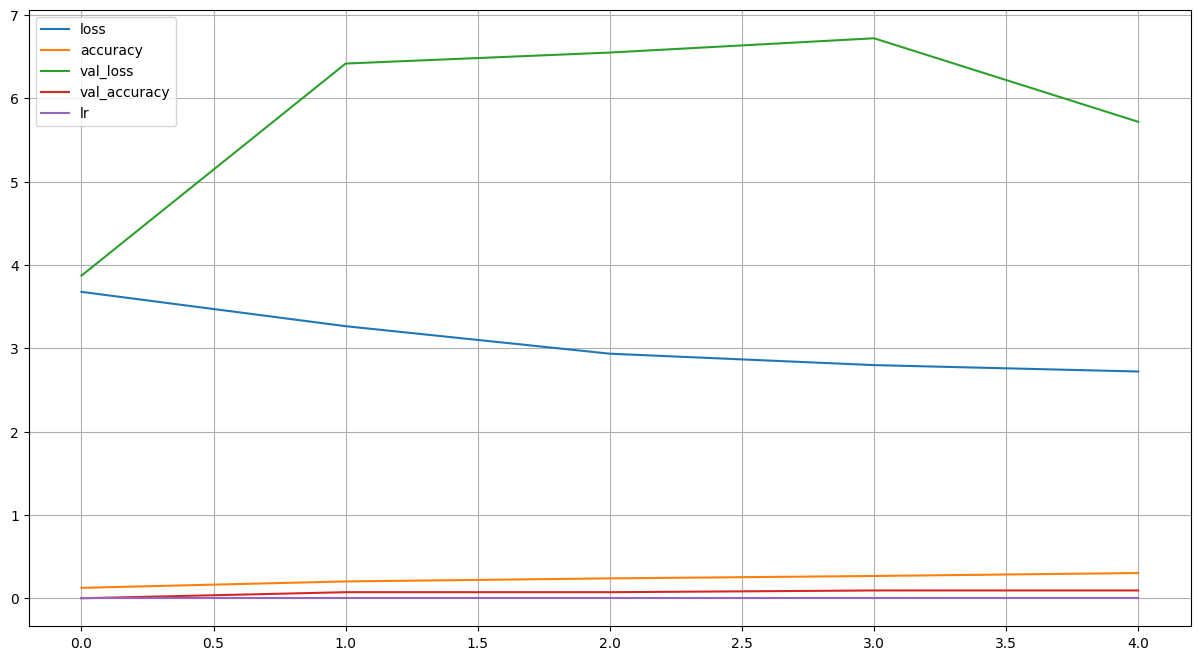

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(15,8))
plt.grid(True)
plt.gca()
plt.show()

In [ ]:
class_names = list(class_labels.values())

In [ ]:
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np


class_labels = test_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())

#Confusion Matrix and Classification Report
y_pred=model.predict(test_generator,steps=test_generator.n/batch_size,verbose=1)
y_pred = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))


print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(y_true, y_pred, target_names=class_names))

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(test_generator.classes, y_pred)


5/5 [==============================] - 1s 212ms/step
Confusion Matrix
[[ 0  0  8  0  0  2  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 10  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  3  0  0  7  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0  8  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  8  0  0  1  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  9  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  0  5  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  6  0  0  4  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  9  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  5  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  4  0  0  6  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 10  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
Classificat

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<Figure size 800x800 with 0 Axes>

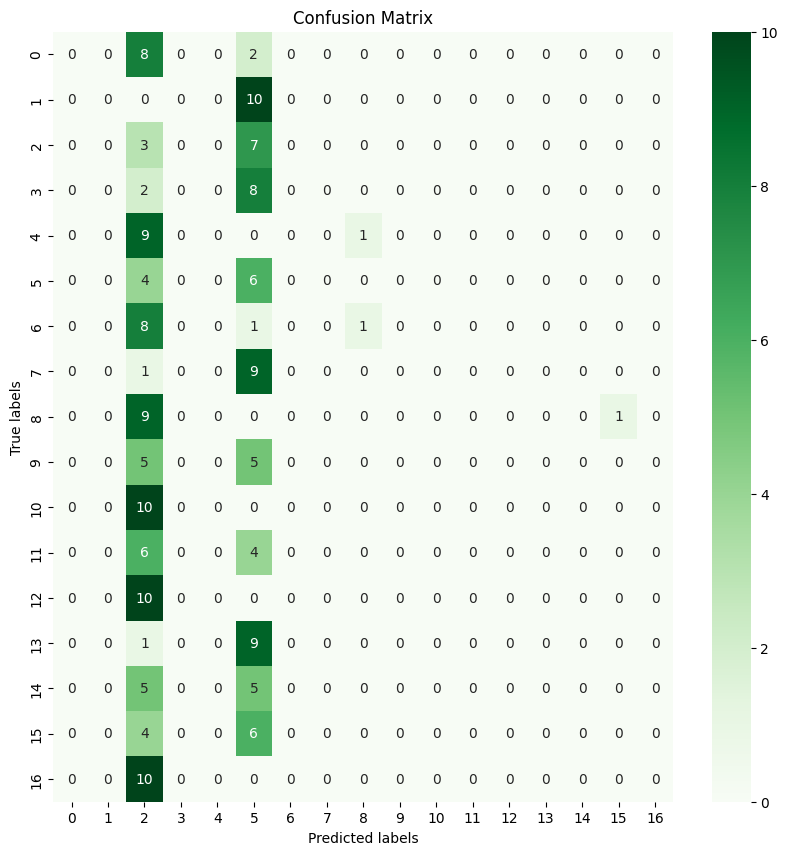

In [ ]:
import seaborn as sb

# ax = plt.figure(figsize=(8, 6))
fig = sb.heatmap(cnf_matrix, annot=True, fmt='g', cmap='Greens')  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
fig.set_xlabel('Predicted labels')
fig.set_ylabel('True labels')
fig.set_title('Confusion Matrix')
fig.figure.set_size_inches(10, 10)


plt.show()

In [ ]:
# Calculate the accuracy
accuracy = accuracy_score(y_true, y_pred)
print("\nAccuracy: {:.4f}".format(accuracy))


Accuracy: 0.0529


In [ ]:
from sklearn.metrics import classification_report

# Assuming y_test holds the true labels and y_classes holds the predicted labels
# Calculate classification report
report_dict = classification_report(y_true, y_pred, output_dict=True)

# Now, you can access the average values
macro_precision = report_dict['macro avg']['precision']
macro_recall = report_dict['macro avg']['recall']
macro_f1 = report_dict['macro avg']['f1-score']

weighted_precision = report_dict['weighted avg']['precision']
weighted_recall = report_dict['weighted avg']['recall']
weighted_f1 = report_dict['weighted avg']['f1-score']


# Print out the averages
print(f"Macro Average Precision: {macro_precision:.4f}")
print(f"Macro Average Recall: {macro_recall:.4f}")
print(f"Macro Average F1-score: {macro_f1:.4f}\n")

print(f"Weighted Average Precision: {weighted_precision:.4f}")
print(f"Weighted Average Recall: {weighted_recall:.4f}")
print(f"Weighted Average F1-score: {weighted_f1:.4f}\n")

Macro Average Precision: 0.0068
Macro Average Recall: 0.0529
Macro Average F1-score: 0.0120

Weighted Average Precision: 0.0068
Weighted Average Recall: 0.0529
Weighted Average F1-score: 0.0120



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
